# Resume Classifier

**Objective:**<br>
Develop a resume classifier in Python using only the visual characteristics of an image. The goal is to accurately classify whether a given image is a resume or not without utilizing OCR or any textual features. The assignment involves collating a dataset, performing necessary augmentations and preprocessing, building and/or training a suitable model, testing the model's performance, and presenting the results through a confusion matrix.

In [1]:
# All the import statements
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import warnings 
warnings.filterwarnings('ignore')

## Dataset

The dataset was created from various sources, with a portion derived from [Kaggle's Real World Documents Collections](https://www.kaggle.com/datasets/shaz13/real-world-documents-collections). The data underwent careful manual preparation to ensure accuracy and relevance. This diverse collection serves as a valuable resource for analysis and research, offering insights from real-world documents to enhance understanding.

In [2]:
# Path of resume and non-resume directories
resume_dir = '/kaggle/input/resume-classifer-dataset/dataset/resume'
non_resume_dir = '/kaggle/input/resume-classifer-dataset/dataset/non-resume'

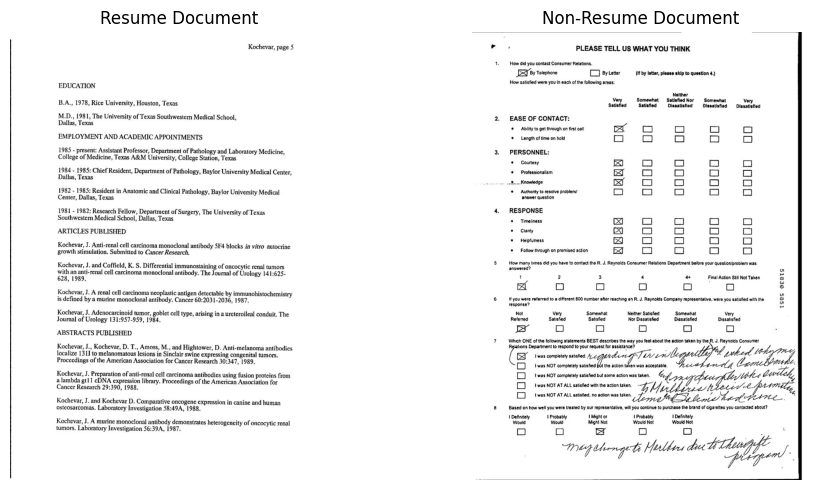

In [15]:
# Display images from a directory
def display_random_image(directory, label, subplot_index):
    files = os.listdir(directory)
    random_image = random.choice(files)
    
    img_path = os.path.join(directory, random_image)
    img = Image.open(img_path).convert('L')  
    
    plt.subplot(1, 2, subplot_index)
    plt.imshow(img, cmap='gray')  # grayscale colormap for black and white
    plt.title(f"{label} Document")
    plt.axis('off')


plt.figure(figsize=(10, 5))

# Display resume image
display_random_image(resume_dir, "Resume", 1)

# Display non-resume image
display_random_image(non_resume_dir, "Non-Resume", 2)

# Displaying both images
plt.tight_layout()
plt.show()

## Train Test Split 
In this step, the dataset undergoes division into training and validation sets, specifically for both resume and non-resume images. This separation precedes the application of data augmentation techniques. By segmenting the data into distinct subsets, we establish robust training and validation protocols essential for the subsequent enhancement of the dataset through augmentation processes

In [4]:
# Load file names from resume and non-resume directories
resume_images = [os.path.join(resume_dir, filename) for filename in os.listdir(resume_dir) if filename.endswith(('.jpg', '.png'))]
non_resume_images = [os.path.join(non_resume_dir, filename) for filename in os.listdir(non_resume_dir) if filename.endswith(('.jpg', '.png'))]

# Split data into training and validation sets
train_resume, val_resume = train_test_split(resume_images, test_size=0.2, random_state=42)
train_non_resume, val_non_resume = train_test_split(non_resume_images, test_size=0.2, random_state=42)

## Data Augmentation

Data augmentation is a technique used to artificially increase the diversity of a dataset by applying various transformations to the existing data. This process involves modifications such as rotation, flipping, and scaling, which help improve model generalization and performance by exposing it to a broader range of scenarios during training.<br>
<br>
Here, ImageDataGenerator instance named datagen with various attributes for data augmentation. It includes rotation (5-degree range), horizontal and vertical shifts (20% range), shearing (20% range), zooming (20% range), and a fill mode for handling empty pixels. The rescale parameter ensures pixel values are normalized to the range [0, 1]. This configuration enables the generator to dynamically apply these transformations, enhancing the dataset's diversity and augmenting the model's ability to generalize effectively during training.

In [5]:
# Create train and val directories
train_dir = '/kaggle/working/augmented-images/train'
val_dir = '/kaggle/working/augmented-images/val'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [6]:
size = 224  # input size 

# ImageDataGenerator instances for data augmentation
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode="nearest",
    rescale=1./255  
)

In [7]:
#  Creating DataFrame with columns 'file_path' and 'class_label'  
# Here 'class_label' contains '0' value for non-resume and '1' value for resume
df_train = pd.DataFrame({
    'file_path': train_resume + train_non_resume,
    'class_label': ['1'] * len(train_resume) + ['0'] * len(train_non_resume)
})

df_val = pd.DataFrame({
    'file_path': val_resume + val_non_resume,
    'class_label': ['1'] * len(val_resume) + ['0'] * len(val_non_resume)
})

# Creating separate generators for training and validation
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='file_path',
    y_col='class_label',
    target_size=(size,size),
    batch_size=32,
    class_mode='binary'
)

val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='file_path',
    y_col='class_label',
    target_size=(size,size),
    batch_size=32,
    class_mode='binary'
)

Found 504 validated image filenames belonging to 2 classes.
Found 126 validated image filenames belonging to 2 classes.


## Model Selection and Architecture

The problem at hand revolves around image classification, necessitating the selection of an appropriate model. Several notable options exist, including VGG16, ResNet, Inception, traditional CNN models, and the Vision Transformer (ViT). Among these, the DenseNet architecture has been specifically chosen for this task.<br>
<br>
<br>
![DenseNet 121 Architecture](https://www.researchgate.net/publication/334170752/figure/fig5/AS:776225345785857@1562077952441/A-schematic-illustration-of-the-DenseNet-121-architecture-82.png)
<br>
<br>
DenseNet is chosen over other models for the Resume Classifier due to its distinctive architecture, which fosters strong feature reuse and efficient parameter sharing. In DenseNet, each layer receives direct input from all preceding layers, promoting feature propagation and enhancing model expressiveness. This dense connectivity results in more compact models with fewer parameters, reducing the risk of overfitting. For tasks like resume classification, where intricate patterns may exist, DenseNet's ability to capture complex relationships between features makes it a compelling choice for achieving high accuracy and effective generalization.

In [8]:
# Load the DenseNet121 model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(size, size, 3))

29084464/29084464 [==============================] - 0s 0us/step


The DenseNet121 base model's convolutional layers are frozen to retain pre-trained features. A new model is then constructed by appending additional layers tailored for the specific problem. The architecture includes a flattening layer, followed by a dense layer with 256 neurons and ReLU activation. To mitigate overfitting, a dropout layer with a rate of 0.2 is introduced. The final layer employs sigmoid activation for binary classification. The model is compiled using the Adam optimizer and binary crossentropy loss. This tailored combination of layers enhances the base DenseNet for effective resume classification.

In [9]:
# Freezing the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Created a new model
model = Sequential()

# Adding the DenseNet121 base model
model.add(base_model)

# Adding additional layers for classification
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # sigmoid activation is used for binary classification

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 19883073 (75.85 MB)
Trainable params: 12845569 (49.00 MB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [10]:
# Defining a model checkpoint callback
checkpoint_filepath = '/kaggle/working/best_checkpoint.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1, 
)

## Model Training

Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 3.8284 - accuracy: 0.7103
Epoch 1: val_accuracy improved from -inf to 0.79365, saving model to /kaggle/working/best_checkpoint.h5
16/16 [==============================] - 31s 1s/step - loss: 3.8284 - accuracy: 0.7103 - val_loss: 1.6343 - val_accuracy: 0.7937
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 1.8672 - accuracy: 0.7460
Epoch 2: val_accuracy improved from 0.79365 to 0.80159, saving model to /kaggle/working/best_checkpoint.h5
16/16 [==============================] - 11s 667ms/step - loss: 1.8672 - accuracy: 0.7460 - val_loss: 1.3749 - val_accuracy: 0.8016
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 0.8886 - accuracy: 0.8492
Epoch 3: val_accuracy did not improve from 0.80159
16/16 [==============================] - 9s 589ms/step - loss: 0.8886 - accuracy: 0.8492 - val_loss: 1.4813 - val_accuracy: 0.7698
Epoch 4/30
16/16 [==============================] - ETA: 0s - lo

<Axes: >

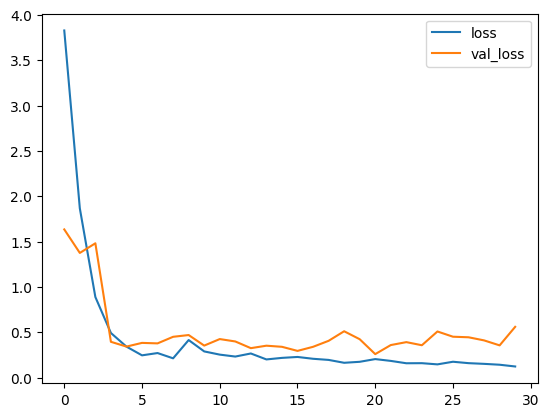

In [11]:
# Training the model and displaying the loss and val_loss during training
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[model_checkpoint]
)
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()

#### Loading the saved model

In [12]:
# Loading the model from the directory
model = load_model('/kaggle/working/best_checkpoint.h5')

## Testing and Evaluation

In [13]:
evaluation_result = model.evaluate(val_generator, steps=len(val_generator))

print("Loss:", evaluation_result[0])
print("Validation Accuracy:", evaluation_result[1])

4/4 [==============================] - 4s 488ms/step - loss: 0.3418 - accuracy: 0.8571
Loss: 0.34180116653442383
Validation Accuracy: 0.8571428656578064


The model exhibits strong performance, achieving an 85% validation accuracy with a low validation loss of 0.34180. This outcome underscores the model's effectiveness in accurately classifying data, indicating its robust learning and generalization 

### Predictions and Confusion Matrix


A confusion matrix is a tabular representation of a classification model's performance, showcasing the counts of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). **True positives** represent correctly identified positive instances, **false positives** indicate incorrect positive predictions, and **false negatives** denote missed positive instances. These metrics are crucial for assessing a model's accuracy, precision, recall, and F1-score. **True positives** highlight successful positive classifications, **false positives** reveal instances of misclassification, and **false negatives** depict instances where the model failed to recognize positive cases. Balancing these metrics is essential for a comprehensive evaluation of model performance.

1/1 [==============================] - 0s 28ms/step
Image: resume2.png, Prediction: 1
Image: resume6.png, Prediction: 0
Image: resume7.png, Prediction: 1
Image: resume5.png, Prediction: 1
Image: resume3.png, Prediction: 1
Image: resume1.png, Prediction: 1
Image: resume8.png, Prediction: 0
Image: non-resume2.png, Prediction: 0
Image: non-resume6.jpg, Prediction: 0
Image: non-resume7.jpg, Prediction: 0
Image: non-resume1.jpeg, Prediction: 0
Image: non-resume5.jpg, Prediction: 0
Image: non-resume3.png, Prediction: 1
Image: non-resume4.jpeg, Prediction: 0


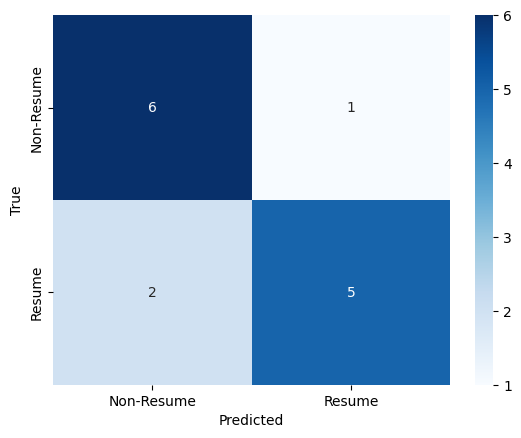

              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.83      0.71      0.77         7

    accuracy                           0.79        14
   macro avg       0.79      0.79      0.78        14
weighted avg       0.79      0.79      0.78        14



In [14]:
# Path to the directory containing new images
new_images_dir = '/kaggle/input/resume-test-images/test_images'

predictions = []
true_labels = []

# Iterate over each sub-directory (resume and non-resume)
for sub_dir in os.listdir(new_images_dir):
    sub_dir_path = os.path.join(new_images_dir, sub_dir)
    
    if not os.path.isdir(sub_dir_path):
        continue

    # Iterate over each image in the sub-directory
    for filename in os.listdir(sub_dir_path):
        img_path = os.path.join(sub_dir_path, filename)

        # Loading and preprocess the image
        img = image.load_img(img_path, target_size=(size, size))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalizing the pixel values to range [0,1]

        # Prediction for new images
        prediction = model.predict(img_array)

        binary_prediction = 1 if prediction[0][0] > 0.5 else 0

        # Append the result to the predictions list
        predictions.append({
            'filename': filename,
            'prediction': binary_prediction,
        })

        # Determine the true label based on the sub-directory
        true_label = 1 if sub_dir == 'resume' else 0
        true_labels.append(true_label)

# Display the predictions
for result in predictions:
    print(f"Image: {result['filename']}, Prediction: {result['prediction']}")

# Create and display confusion matrix
conf_matrix = confusion_matrix(true_labels, [result['prediction'] for result in predictions])

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Resume', 'Resume'], yticklabels=['Non-Resume', 'Resume'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print(classification_report(true_labels, [result['prediction'] for result in predictions]))


The confusion matrix represents two classes: "non-resume" (class 0) and "resume" (class 1). The precision for "non-resume" is 0.75, and for "resume" it's 0.83, indicating the accuracy of positive predictions for each class. However, "resume" exhibits lower recall (0.71), suggesting instances where positive cases were missed. The overall accuracy is 79%, and the macro and weighted averages for precision, recall, and F1-score are approximately 0.79, reflecting a balanced performance evaluation. The model demonstrates a decent ability to correctly classify instances, with room for improvement in recall for "resume" instances.

**Model Strengths:** 
* Dense Connectivity 
* Light model
* Decisive Performance
* Suitability for Limited Data

**Model Limitations:**
* Limited Contextual Understanding
* Dependency on Image Quality
* Imbalance Handling
* Resource Intensiveness

## Conclusion

The DenseNet-based resume classification model exhibits commendable accuracy and precision. The achieved 85% validation accuracy and associated metrics reflect its effectiveness in distinguishing between resume and non-resume images. To further enhance its performance, providing a more diverse and comprehensive dataset, both qualitatively and quantitatively, would contribute to refining the model's robustness and generalization capabilities.